In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

2025-04-08 17:00:13.585000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744131613.605929  993521 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744131613.612441  993521 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 17:00:13.634931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_structure_data(df):
    """Structure data preparation without contacts"""
    features_list = []
    middle_pos = 16  
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array, pos):
        angles = np.array([arr[pos] for arr in angle_array])
        angle_rad = np.pi * angles / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # 1. Process angles
    angles = ['phi', 'psi', 'omega']
    for angle in angles:
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        angle_features = normalize_angles(angle_arrays, middle_pos)
        features_list.append(angle_features)
        print(f"{angle} features shape: {angle_features.shape}")
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_features = []
    for pos in [middle_pos-1, middle_pos, middle_pos+1]:
        sasa_pos = np.array([arr[pos] for arr in sasa_arrays]).reshape(-1, 1)
        sasa_scaled = scaler.fit_transform(sasa_pos)
        sasa_features.append(sasa_scaled)
    sasa_features = np.concatenate(sasa_features, axis=1)
    features_list.append(sasa_features)
    print(f"SASA features shape: {sasa_features.shape}")
    
    # 3. Process chi angles
    chi_angles = ['chi1', 'chi2', 'chi3', 'chi4']
    for chi in chi_angles:
        chi_arrays = np.array([np.array(eval(x)) for x in df[chi]])
        chi_features = normalize_angles(chi_arrays, middle_pos)
        features_list.append(chi_features)
        print(f"{chi} features shape: {chi_features.shape}")
    
    # 4. Process SS (optional)
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_center = ss_arrays[:, middle_pos]
    ss_encoded = np.zeros((len(ss_arrays), 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i, ss in enumerate(ss_center):
        ss_encoded[i, ss_map[ss]] = 1
    features_list.append(ss_encoded)
    print(f"SS features shape: {ss_encoded.shape}")
    
    # 5. Process plDDT
    plddt_arrays = np.array([np.array(eval(x)) for x in df['plDDT']])
    plddt_center = np.array([arr[middle_pos] for arr in plddt_arrays]).reshape(-1, 1)
    scaler = RobustScaler()
    plddt_scaled = scaler.fit_transform(plddt_center)
    features_list.append(plddt_scaled)
    print(f"plDDT features shape: {plddt_scaled.shape}")
    
    # Combine all features
    features = np.concatenate(features_list, axis=1)
    print(f"\nFinal combined features shape: {features.shape}")
    print("Feature list lengths:", [f.shape[1] for f in features_list])
    
    return features

In [4]:
def create_snn_model(input_dim):
    """Create a Self-Normalizing Neural Network model"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='selu', 
                             kernel_initializer='lecun_normal'),
        tf.keras.layers.AlphaDropout(0.2),  # Special dropout for SELU
        tf.keras.layers.Dense(64, activation='selu', 
                             kernel_initializer='lecun_normal'),
        tf.keras.layers.AlphaDropout(0.2),
        tf.keras.layers.Dense(32, activation='selu', 
                             kernel_initializer='lecun_normal'),
        tf.keras.layers.AlphaDropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [5]:
def print_metrics(y_true, y_pred):
    """
    Print comprehensive evaluation metrics
    
    Parameters:
    y_true: array-like of true labels
    y_pred: array-like of predicted labels
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])  # True Positive Rate
    specificity = cm[0][0] / (cm[0][0] + cm[0][1])  # True Negative Rate
    
    # Print results
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [ ]:
def train_and_evaluate_seq_only():
    """Train and evaluate structure-based model"""
    print("Loading structural data...")
    
    # Load data
    train_df = pd.read_csv("../../../../data/train/structure/processed_features_train.csv")
    test_df = pd.read_csv("../../../../data/test/structure/processed_features_test.csv")
    
    # Extract labels
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Prepare feature data
    X_train = prepare_structure_data(train_df)
    X_test = prepare_structure_data(test_df)
    
    # Shuffle training data (important since negatives come first, then positives)
    shuffle_idx = np.random.RandomState(42).permutation(len(y_train))
    X_train = X_train[shuffle_idx]
    y_train = y_train[shuffle_idx]
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    print(f"Class weights: {class_weights}")
    
    # Cross-validation setup
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_snn_model(X_train.shape[1])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            X_train[train_idx], 
            y_train[train_idx],
            validation_data=(
                X_train[val_idx], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        val_pred = model.predict(X_train[val_idx])
        val_pred_binary = (val_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], val_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], val_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], val_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], val_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict(X_test)
        test_predictions.append(test_pred)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model, test_pred_avg

Loading structural data...
phi features shape: (8853, 2)
psi features shape: (8853, 2)
omega features shape: (8853, 2)
SASA features shape: (8853, 3)
chi1 features shape: (8853, 2)
chi2 features shape: (8853, 2)
chi3 features shape: (8853, 2)
chi4 features shape: (8853, 2)
SS features shape: (8853, 3)
plDDT features shape: (8853, 1)

Final combined features shape: (8853, 21)
Feature list lengths: [2, 2, 2, 3, 2, 2, 2, 2, 3, 1]
phi features shape: (2737, 2)
psi features shape: (2737, 2)
omega features shape: (2737, 2)
SASA features shape: (2737, 3)
chi1 features shape: (2737, 2)
chi2 features shape: (2737, 2)
chi3 features shape: (2737, 2)
chi4 features shape: (2737, 2)
SS features shape: (2737, 3)
plDDT features shape: (2737, 1)

Final combined features shape: (2737, 21)
Feature list lengths: [2, 2, 2, 3, 2, 2, 2, 2, 3, 1]
Training data shape: (8853, 21)
Testing data shape: (2737, 21)
Class weights: {0: 1.0388406477352734, 1: 0.9639590592334495}

Fold 1/5


I0000 00:00:1744131638.979859  993521 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 503 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0


Epoch 1/50


2025-04-08 17:00:39.668619: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5443 - loss: 0.7716 - val_accuracy: 0.5449 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5553 - loss: 0.6908 - val_accuracy: 0.6036 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5774 - loss: 0.6751 - val_accuracy: 0.6138 - val_loss: 0.6568 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5769 - loss: 0.6746 - val_accuracy: 0.5991 - val_loss: 0.6662 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5844 - loss: 0.6707 - val_accuracy: 0.6093 - val_loss: 0.6570 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5917 - loss: 0.6667 - val_accuracy: 0.6121 - val_loss: 0.6553 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5912 - loss: 0.6646 - val_accurac

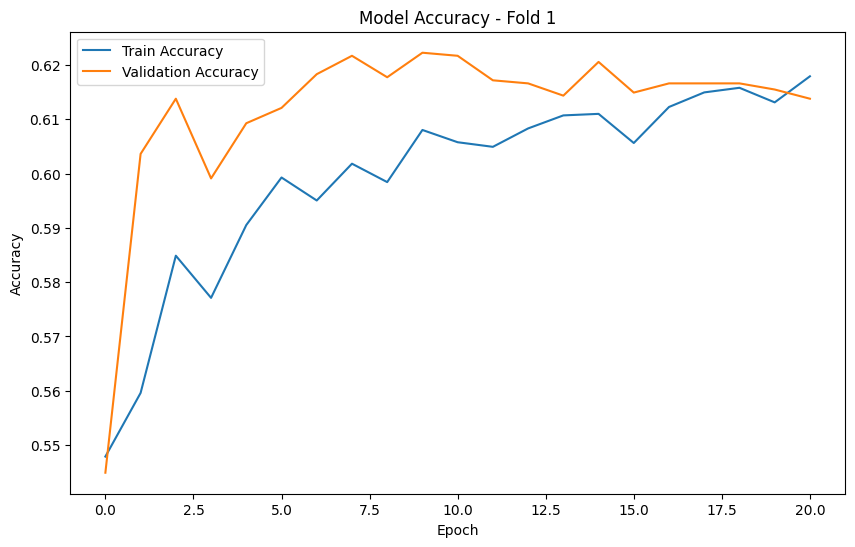

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 17:01:05.607939: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 1 Results:
Accuracy: 0.6217
Balanced Accuracy: 0.6232
MCC: 0.2468
Sensitivity: 0.5832
Specificity: 0.6631

Fold 2/5
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5270 - loss: 0.7578 - val_accuracy: 0.5997 - val_loss: 0.6624 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5760 - loss: 0.6795 - val_accuracy: 0.5991 - val_loss: 0.6644 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5891 - loss: 0.6678 - val_accuracy: 0.6341 - val_loss: 0.6568 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5987 - loss: 0.6652 - val_accuracy: 0.6290 - val_loss: 0.6583 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5908 - loss: 0.6657 - val_accuracy: 0.6307 - val_loss: 0.6530 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6002 - loss: 

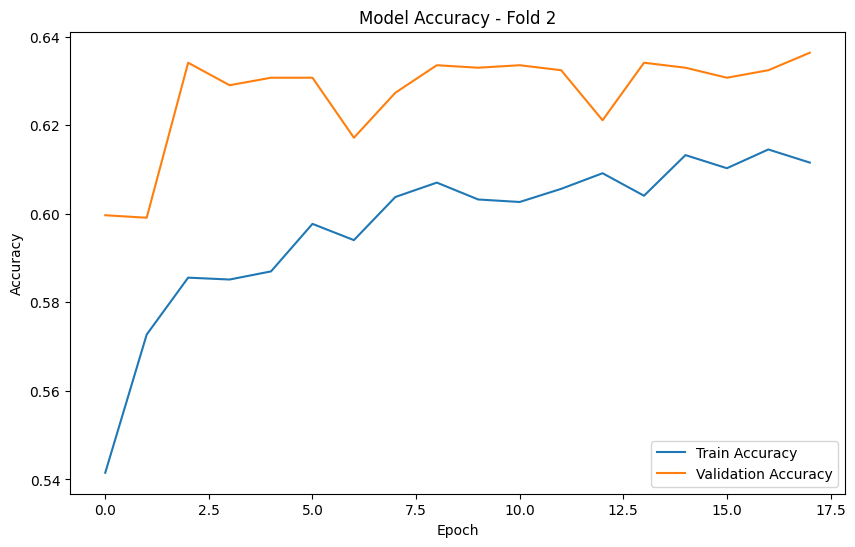

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 17:01:27.909822: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 2 Results:
Accuracy: 0.6273
Balanced Accuracy: 0.6286
MCC: 0.2574
Sensitivity: 0.5952
Specificity: 0.6620

Fold 3/5
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5275 - loss: 0.7733 - val_accuracy: 0.5912 - val_loss: 0.6637 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5709 - loss: 0.6819 - val_accuracy: 0.6228 - val_loss: 0.6601 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5819 - loss: 0.6756 - val_accuracy: 0.6245 - val_loss: 0.6583 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5986 - loss: 0.6659 - val_accuracy: 0.6256 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5976 - loss: 0.6637 - val_accuracy: 0.6245 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5983 - loss: 

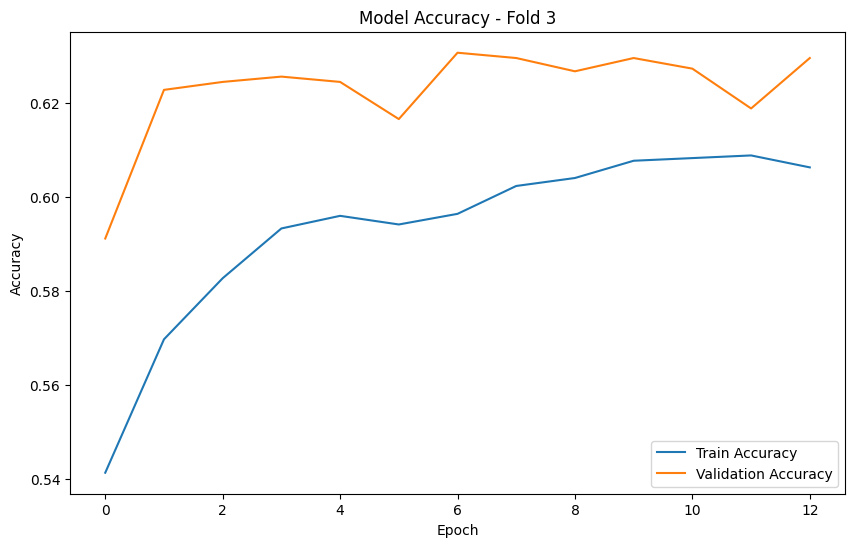

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 17:01:46.482216: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 3 Results:
Accuracy: 0.6245
Balanced Accuracy: 0.6206
MCC: 0.2472
Sensitivity: 0.7277
Specificity: 0.5135

Fold 4/5
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5495 - loss: 0.7777 - val_accuracy: 0.5898 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5747 - loss: 0.6861 - val_accuracy: 0.5927 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5836 - loss: 0.6796 - val_accuracy: 0.6130 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5987 - loss: 0.6674 - val_accuracy: 0.6045 - val_loss: 0.6732 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5934 - loss: 0.6677 - val_accuracy: 0.6068 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6092 - loss: 

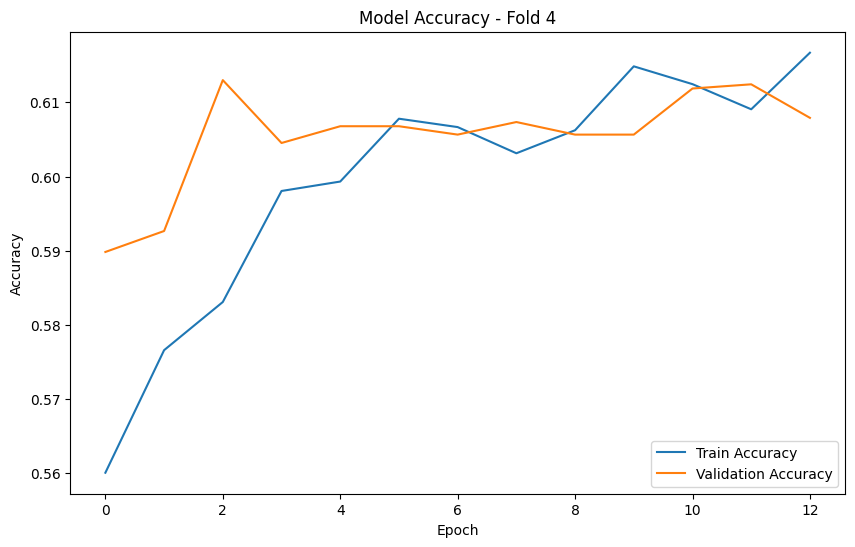

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 17:02:04.269795: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 4 Results:
Accuracy: 0.6130
Balanced Accuracy: 0.6091
MCC: 0.2234
Sensitivity: 0.7146
Specificity: 0.5035

Fold 5/5
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5230 - loss: 0.7821 - val_accuracy: 0.5876 - val_loss: 0.6713 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5779 - loss: 0.6811 - val_accuracy: 0.5802 - val_loss: 0.6679 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5881 - loss: 0.6695 - val_accuracy: 0.5859 - val_loss: 0.6709 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6091 - loss: 0.6605 - val_accuracy: 0.5864 - val_loss: 0.6675 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6106 - loss: 0.6563 - val_accuracy: 0.5960 - val_loss: 0.6659 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6113 - loss: 

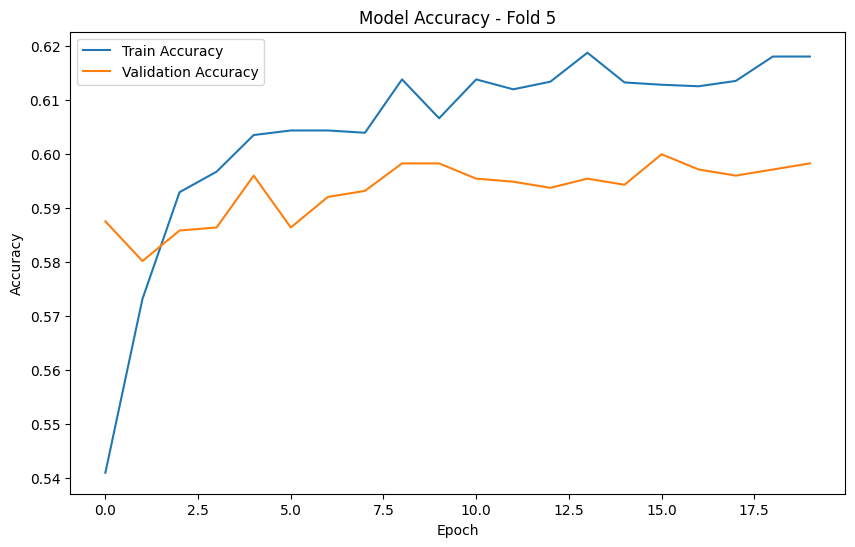

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 17:02:30.233462: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 5 Results:
Accuracy: 0.5983
Balanced Accuracy: 0.5922
MCC: 0.1956
Sensitivity: 0.7571
Specificity: 0.4272

Average Cross-validation Results:
ACC: 0.6170 ± 0.0105
BALANCED_ACC: 0.6147 ± 0.0130
MCC: 0.2341 ± 0.0222
SN: 0.6756 ± 0.0719
SP: 0.5539 ± 0.0936

Final Test Set Results:
Accuracy: 0.4761
Balanced Accuracy: 0.5848
MCC: 0.0967
Sensitivity: 0.7167
Specificity: 0.4529
Confusion Matrix:
[[1131 1366]
 [  68  172]]


In [ ]:
model, test_probs = train_and_evaluate_seq_only()